In [1]:
import os
import h5py
import pandas as pd
import shutil
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
with h5py.File('test-image.hdf5', 'r') as f:
    for name in f:
        data = f[name][()]
        with open(f"{name}.jpg", "wb") as img_file:  
            img_file.write(data)

In [3]:
root = r'C:\Users\LENOVO\OneDrive\Desktop\Python\Datasets\isis\train-image\image'

In [4]:
dataPath = r'C:\Users\LENOVO\OneDrive\Desktop\Python\Datasets\isis\train-metadata.csv'
metadata = pd.read_csv(dataPath)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28184\1623077572.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(dataPath)


In [5]:
benign_id = metadata[metadata.target == 0].isic_id.copy()

In [6]:
train_split = int(benign_id.shape[0]*0.999)
train_split

400265

In [26]:
os.makedirs('train_images', exist_ok=True)
os.makedirs('val_images', exist_ok=True)

In [28]:
dst = r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\train_images'
not_exists = []

for benign in benign_id.values[:train_split]:
    image = benign + '.jpg'
    src = os.path.join(root, image)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        not_exists.append(benign)

In [29]:
dst = r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\val_images'

for benign in benign_id.values[train_split:]:
    image = benign + '.jpg'
    src = os.path.join(root, image)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        not_exists.append(benign)

In [7]:
malignant_id = metadata[metadata.target == 1].isic_id.copy()

In [31]:
dst = r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\val_images'

for malignant in malignant_id.values:
    image = malignant + '.jpg'
    src = os.path.join(root, image)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        not_exists.append(malignant)

In [33]:
len(not_exists)

3146

In [38]:
image_dir = r'c:\Users\LENOVO\Desktop\Python\Datasets\isis\train_images'
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.jpg', '.jpeg', '.png'))]

In [71]:
os.makedirs(r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\train_images\images', exist_ok=True)
dst = r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\train_images\images'

for image in image_paths:
    shutil.move(image, dst)

In [75]:
val_dir = r'c:\Users\LENOVO\Desktop\Python\Datasets\isis\val_images'
val_paths = [os.path.join(val_dir, fname) for fname in os.listdir(val_dir) if fname.endswith(('.jpg', '.jpeg', '.png'))]

In [76]:
os.makedirs(r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\val_images\images', exist_ok=True)
dst = r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\val_images\images'

for val in val_paths:
    shutil.move(val, dst)

In [83]:
train_generator = tf.keras.utils.image_dataset_from_directory(r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\train_images',
                                                        validation_split=0.2,
                                                        batch_size=None,
                                                        subset='training',
                                                        image_size=(128, 128),
                                                        seed=42)

val_generator = tf.keras.utils.image_dataset_from_directory(r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\train_images',
                                                        validation_split=0.2,
                                                        batch_size=None,
                                                        subset='validation',
                                                        image_size=(128, 128),
                                                        seed=42)

Found 397179 files belonging to 1 classes.
Using 317744 files for training.
Found 397179 files belonging to 1 classes.
Using 79435 files for validation.


In [91]:
train_data = train_generator.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(x, tf.float32) / 255.0)).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_generator.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(x, tf.float32) / 255.0)).batch(32).prefetch(tf.data.AUTOTUNE)

In [260]:
# Input
input_img = tf.keras.layers.Input(shape=(128, 128, 3))

# Encoder
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)  

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)  

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)  

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)  

x = tf.keras.layers.Flatten()(x)
encoded = tf.keras.layers.Dense(128, activation='relu')(x)  

# ---------------- Decoder ----------------
x = tf.keras.layers.Dense(8 * 8 * 256, activation='relu')(encoded)
x = tf.keras.layers.Reshape((8, 8, 256))(x)

x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)  
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)  
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)  
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same')(x) 
x = tf.keras.layers.BatchNormalization()(x)

decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

encoder = tf.keras.Model(input_img, encoded, name='encoder')
autoencoder = tf.keras.Model(input_img, decoded, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 4,994,467 (19.05 MB)

 Trainable params: 4,993,027 (19.05 MB)

 Non-trainable params: 1,440 (5.62 KB)

In [196]:
autoencoder.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    metrics=['mse'])

In [197]:
callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

autoencoder.fit(train_data,
                validation_data=val_data,
                epochs=20,
                steps_per_epoch=500,
                validation_steps=50,
                callbacks=callback)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 313s 620ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 308s 615ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 308s 617ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 313s 625ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 330s 660ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 9.2574e-04 - val_mse: 9.2574e-04
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1924s 4s/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 317s 634ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 7.5543e-04 - val_mse: 7.5543e-04
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 382s 765ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 6.7221e-04 - val_mse: 6.7221e-04
Ep

In [108]:
anomaly = r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\val_images\images'
images = []
labels = []

for image in os.listdir(anomaly):
    isic_id = image.replace(".jpg", "")
    images.append(isic_id)
    labels.append(int(metadata[metadata.isic_id == isic_id].target.values[0]))

In [109]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [2]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [96, 96])
    image = tf.cast(image, tf.float16)
    return image

In [118]:
anomaly_numpy = np.zeros((734, 128, 128, 3))
anomaly_path = r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\val_images\images'

for i, image in enumerate(os.listdir(anomaly_path)):
    path = os.path.join(anomaly_path, image)
    img = load_and_preprocess_image(path)
    anomaly_numpy[i] = img

In [110]:
anomaly_generator = tf.keras.utils.image_dataset_from_directory(r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\val_images',
                                                        batch_size=None,
                                                        image_size=(128, 128),
                                                        seed=42)

Found 734 files belonging to 1 classes.


In [145]:
anomaly_data = tf.data.Dataset.from_tensor_slices((anomaly_numpy)).batch(32).prefetch(tf.data.AUTOTUNE)

In [198]:
prediction = autoencoder.predict(anomaly_data)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step


In [199]:
prediction.shape

(734, 128, 128, 3)

In [ ]:
# Evaluate on dataset
losses = tf.reduce_mean(tf.math.squared_difference(prediction/255.0, anomaly_numpy/255.0), axis=(1, 2, 3)).numpy()

# Top-N highest loss
top_n = 20
high_loss_indices = np.argsort(losses)[:top_n]

# Visualize
for i in high_loss_indices:
    plt.imshow(anomaly_numpy[i]/255.0, cmap='gray')
    plt.title(f"Loss: {losses[i]:.2f}")
    plt.show()

In [202]:
threshold = np.percentile(losses, 15) 
anomalies = anomaly_numpy[losses < threshold]

In [203]:
anomalies.shape

(110, 128, 128, 3)

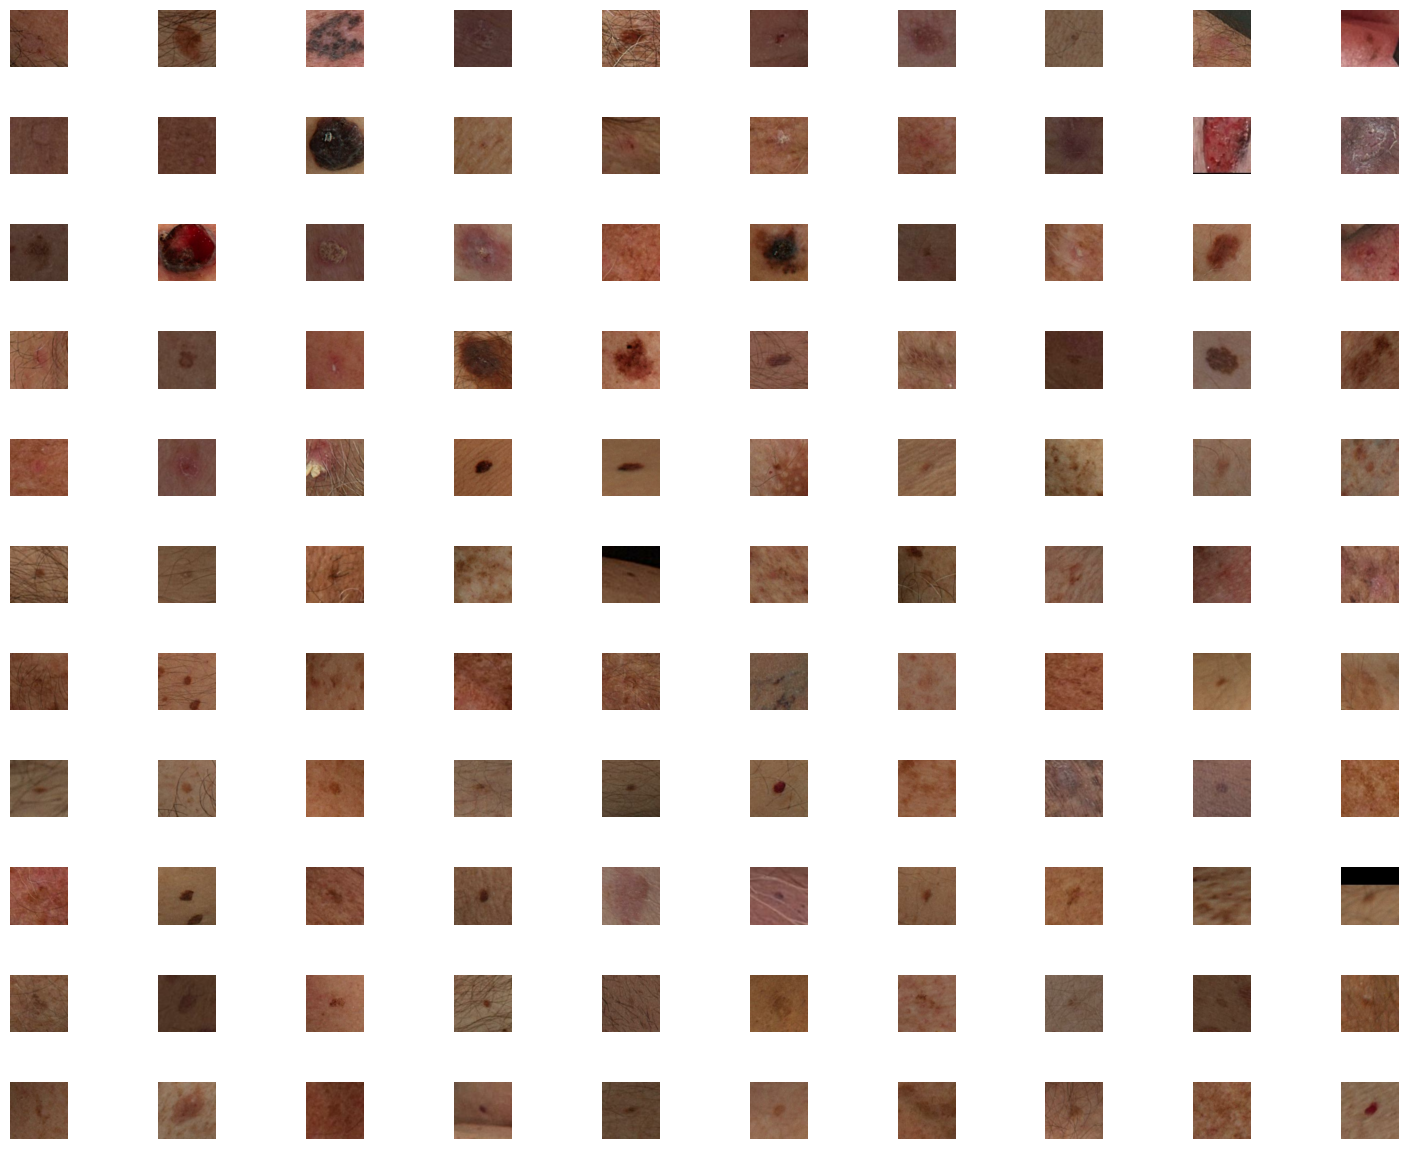

In [204]:
images = anomalies[:anomalies.shape[0]] 

rows, cols = 11, 10

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
fig.tight_layout(pad=1.5)

for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    if i < len(images):
        img = images[i]
        
        if img.max() > 1.0:
            img = img / 255.0
        
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')  

plt.show()

In [224]:
latent_benign = encoder.predict(train_data.take(30))
latent_malignant = encoder.predict(anomaly_data.take(30).shuffle(buffer_size=30))

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


In [225]:
latent_benign = latent_benign.reshape(len(latent_benign), -1)
latent_malignant = latent_malignant.reshape(len(latent_malignant), -1)

In [226]:
X = np.concatenate([latent_benign, latent_malignant], axis=0)
y = np.array([0]*len(latent_benign) + [1]*len(latent_malignant))

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


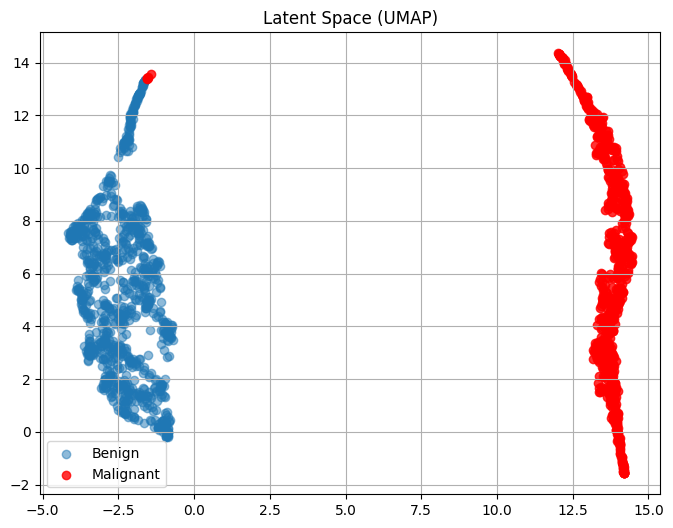

In [227]:
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_umap[y==0, 0], X_umap[y==0, 1], label='Benign', alpha=0.5)
plt.scatter(X_umap[y==1, 0], X_umap[y==1, 1], label='Malignant', alpha=0.8, color='r')
plt.legend()
plt.title('Latent Space (UMAP)')
plt.grid(True)
plt.show()

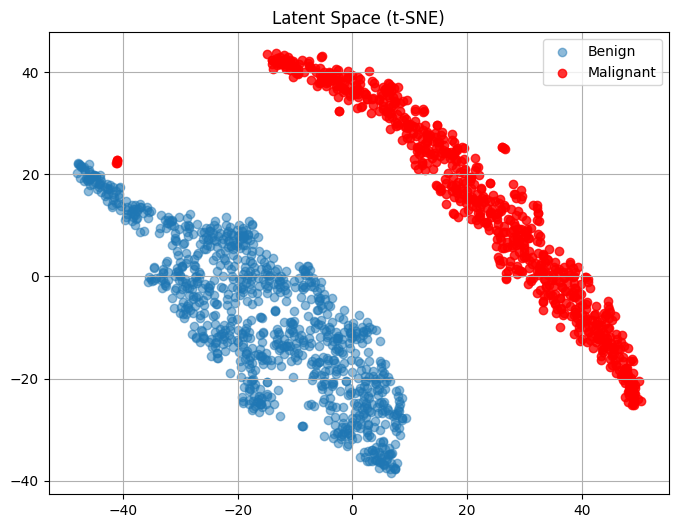

In [228]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], label='Benign', alpha=0.5)
plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], label='Malignant', alpha=0.8, color='r')
plt.legend()
plt.title('Latent Space (t-SNE)')
plt.grid(True)
plt.show()

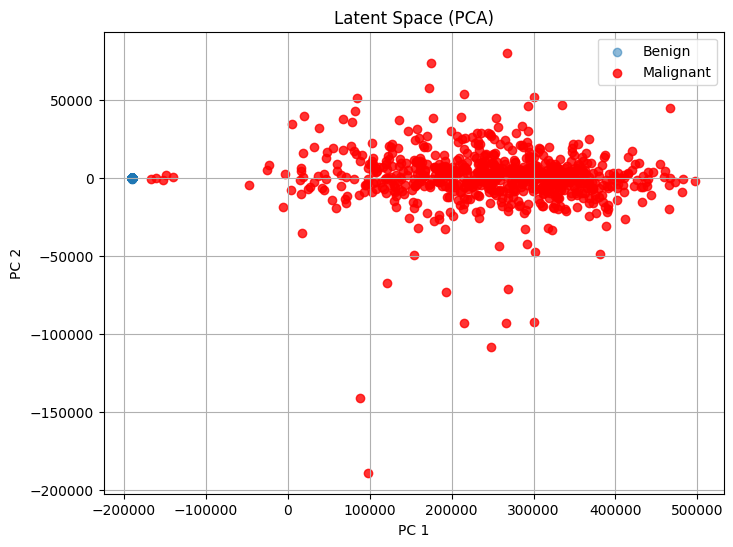

In [229]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], label='Benign', alpha=0.5)
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], label='Malignant', alpha=0.8, color='r')
plt.legend()
plt.title('Latent Space (PCA)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()

In [249]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [250]:
x_train, x_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y,random_state=42)

In [251]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)

lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [252]:
prediction_latent = lr.predict(x_val)

print(accuracy_score(y_val, prediction_latent))
print(precision_score(y_val, prediction_latent))
print(recall_score(y_val, prediction_latent))

1.0
1.0
1.0


In [253]:
x_train.shape

(1355, 32768)

In [254]:
test_data = np.zeros((3, 128, 128, 3))
test_path = r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\test-image'

for i, image in enumerate(os.listdir(test_path)):
    path = os.path.join(test_path, image)
    img = load_and_preprocess_image(path)
    test_data[i] = img

In [255]:
test_encoder = encoder.predict(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [256]:
test_encoder.shape

(3, 16, 16, 128)

In [257]:
test_encoder = test_encoder.reshape((3, 32768))

In [258]:
final_predictions = lr.predict_proba(test_encoder)

In [259]:
final_predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.]])

In [242]:
known = load_and_preprocess_image(r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\train-image\image\ISIC_0015670.jpg')
known = tf.reshape(known, (1, 128, 128, 3))

In [245]:
latent = encoder.predict(known)
latent = tf.reshape(latent, (1, 32768))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [246]:
lr.predict(latent)

array([1])

In [247]:
from collections import Counter
print(Counter(y_train))

Counter({np.int64(0): 755, np.int64(1): 600})
